# Customers Segmentation

In [1]:
!pip install presto-python-client
!pip install pandas plotnine

import prestodb
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 500)

import gc
import os

# matplotlib and seaborn for plotting
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120 #resolution
matplotlib.rcParams['figure.figsize'] = (8,6) #figure size

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
color = sns.color_palette()

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA

## Data

For segmentation I am considering users from prior set only

In [2]:
# limit the data to 1M rows for avoid OFME
conn=prestodb.dbapi.connect(
    host='presto-service',
    port=8282,
    user='presto',
    catalog='hive',
    schema='sample',
)

fetchlimit = 100000

cur = conn.cursor()
cur.execute('show tables')
pd.DataFrame.from_records(cur.fetchall(), columns = [i[0] for i in cur.description])


(1000000, 16)

In [ ]:
# limit the data to 100k rows for avoid OFME
cur.execute('select * from sample.order_products limit ' + str(fetchlimit))
order_products = pd.DataFrame.from_records(cur.fetchall(), columns = [i[0] for i in cur.description])
order_products.shape

In [3]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,...,product_name,aisle_id,aisle,department_id,department
0,347,1158,14,True,17155,...,Mango Chunks,116.0,frozen produce,1.0,frozen
1,347,17304,12,True,17155,...,Powdered Peanut Butter,88.0,spreads,13.0,pantry
2,347,17948,13,True,17155,...,Frozen Organic Wild Blueberries,116.0,frozen produce,1.0,frozen
3,347,18689,7,True,17155,...,Dairy-Free Chive Cream Cheese,108.0,other creams cheeses,16.0,dairy eggs
4,347,21903,5,True,17155,...,Organic Baby Spinach,123.0,packaged vegetables fruits,4.0,produce


In [4]:
order_products.user_id.nunique()

67513

## Segmentation

Since there are thousands of products in the dataset I will rely on aisles, which represent categories of products. Even with aisles features will be too much so I will use Principal Component Analysis to find new dimensions along which clustering will be easier.

In [5]:
cross_df = pd.crosstab(order_products.user_id, order_products.aisle)
cross_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,...,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,
6,0,0,0,0,0,...,0,0,0,0,0
11,0,0,0,0,0,...,0,0,2,0,2
13,0,0,0,0,0,...,0,0,0,0,0
14,0,0,0,0,0,...,0,0,0,0,0
17,0,0,0,0,0,...,0,0,1,0,0


In [6]:
cross_df.tail()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,...,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,
206201,0,2,0,0,0,...,0,0,0,0,0
206206,0,0,0,0,0,...,0,0,0,0,0
206207,0,0,0,0,0,...,0,0,1,0,3
206208,0,0,0,0,0,...,0,0,0,0,0
206209,0,0,0,0,0,...,1,0,0,0,1


I will normalize each row

In [7]:
df = cross_df.div(cross_df.sum(axis=1), axis=0)
df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,...,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,
6,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.000
11,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.125,0.0,0.125
13,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.000
14,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.000
17,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.100,0.0,0.000


In [8]:
df.shape

(67450, 134)

### PCA and K-Means Clustering

Reducing this dataframe to only 10 dimensions as KMeans does not work properly in higher dimension. 

In [9]:
pca = PCA(n_components=10)
df_pca = pca.fit_transform(df)
df_pca = pd.DataFrame(df_pca)
df_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,0.030411,0.415897,0.034859,0.013330,-0.072967,-0.009604,-0.026588,-0.042140,-0.097826,-0.152048
1,-0.161392,-0.064641,0.042068,0.066948,0.038441,0.016309,-0.001333,0.115684,-0.010053,0.052400
2,-0.029020,0.239542,-0.012564,-0.021576,-0.010799,0.125981,0.075192,0.027011,-0.018747,-0.005874
3,-0.066981,0.121876,-0.023134,-0.036528,0.000484,-0.010730,-0.014718,-0.010719,-0.011873,-0.016151
4,-0.069224,-0.095543,0.046138,-0.031581,-0.057087,-0.016563,-0.057917,0.026028,0.058033,0.098403


In [10]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_pca)
    Sum_of_squared_distances.append(km.inertia_)

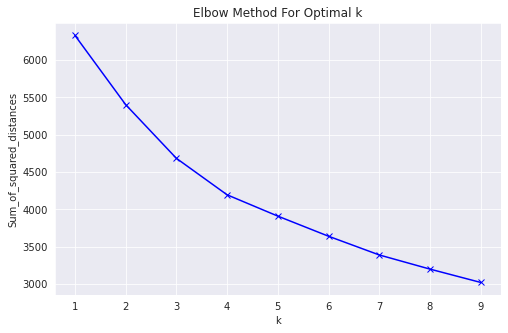

In [11]:
plt.subplots(figsize = (8, 5))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

From above plot we can choose optimal K as 5

In [12]:
clusterer = KMeans(n_clusters=5,random_state=42).fit(df_pca)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(df_pca)
print(centers)

[[-1.09737553e-01 -3.31535183e-02 -3.45065270e-02 -2.25453412e-03
  -2.12241917e-02 -2.65104687e-03 -2.88317197e-03 -5.65491583e-04
  -1.69273463e-03 -1.15722115e-04]
 [ 5.96114447e-02 -3.46876524e-02 -1.31412748e-02 -1.97029919e-03
   3.66019532e-02  4.37819408e-03 -1.59942714e-03 -2.56223127e-03
   3.12481524e-03 -1.21900978e-03]
 [ 6.83969336e-02  2.25520183e-01  2.57723136e-02  5.87141612e-03
  -8.75691246e-03 -1.30168910e-03  4.61329553e-03  3.21550547e-03
  -1.10296137e-03  5.00465954e-04]
 [ 3.51472258e-01 -1.89508839e-01  2.76473165e-02 -6.39360366e-03
  -3.10438298e-02 -5.38259054e-03  7.79987905e-03  6.70377423e-03
  -3.49873347e-03  2.78964870e-03]
 [-2.05940327e-01 -1.22042483e-01  4.86199398e-01  3.60650366e-02
   4.26986292e-02  1.26436199e-02  1.69088883e-02  2.38773915e-03
   6.10782555e-03  6.56125868e-03]]


#### Visualizing clustering among first two principal components

In [31]:
pd.options.mode.chained_assignment = None  # default='warn'
temp_df = df_pca.iloc[:, 0:2]
temp_df.columns = ["pc1", "pc2"]
temp_df['cluster'] = c_preds
temp_df.head()

,pc1,pc2,cluster
0,0.030411,0.415897,2
1,-0.161392,-0.064641,0
2,-0.029020,0.239542,2
3,-0.066981,0.121876,0
4,-0.069224,-0.095543,0


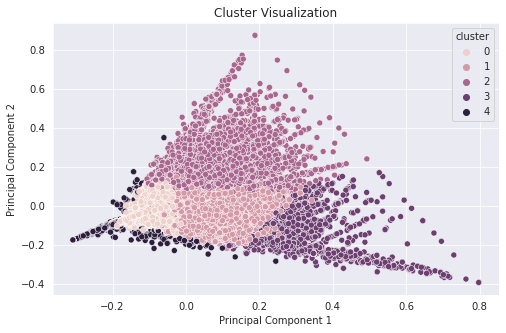

In [14]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.scatterplot(data = temp_df, x = "pc1", y = "pc2", hue = "cluster")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("Cluster Visualization")
plt.show();

### Top products per cluster

In [15]:
cross_df['cluster'] = c_preds

cluster1 = cross_df[cross_df.cluster == 0]
cluster2 = cross_df[cross_df.cluster == 1]
cluster3 = cross_df[cross_df.cluster == 2]
cluster4 = cross_df[cross_df.cluster == 3]
cluster5 = cross_df[cross_df.cluster == 4]

In [16]:
cluster1.shape

(28759, 135)

In [17]:
cluster1.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
yogurt                           0.598595
fresh vegetables                 0.480302
fresh fruits                     0.453701
packaged cheese                  0.440106
chips pretzels                   0.404882
packaged vegetables fruits       0.372509
milk                             0.366911
water seltzer sparkling water    0.350742
ice cream ice                    0.295351
refrigerated                     0.285476
dtype: float64

- Cluster 1 results into 28759 consumers who orders products from many aisles. Their mean orders are low compared to other clusters which tells us that either they are not frequent users of Instacart or they are new users and do not have many orders yet. 

In [18]:
cluster2.shape

(20961, 135)

In [19]:
cluster2.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     3.077716
fresh vegetables                 1.638376
packaged vegetables fruits       1.385239
yogurt                           0.934259
packaged cheese                  0.583512
milk                             0.508945
soy lactosefree                  0.392491
water seltzer sparkling water    0.375889
bread                            0.340537
chips pretzels                   0.337341
dtype: float64

- Cluster 2 results into 20961 consumers who buy fresh fruits and fresh vegetables, and packaged vegetable fruits mostly.

In [20]:
cluster3.shape

(11871, 135)

In [21]:
cluster3.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh vegetables                 4.522281
fresh fruits                     1.673322
packaged vegetables fruits       0.944065
yogurt                           0.421447
packaged cheese                  0.395249
fresh herbs                      0.382613
soy lactosefree                  0.291804
milk                             0.286160
frozen produce                   0.265858
water seltzer sparkling water    0.232415
dtype: float64

- Cluster 3 results into 11871 consumers who mostly order fresh vegetables followed by fruits.

In [22]:
cluster4.shape

(4116, 135)

In [23]:
cluster4.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     3.242711
fresh vegetables                 0.374879
packaged vegetables fruits       0.334062
packaged produce                 0.265792
milk                             0.212099
yogurt                           0.179300
soy lactosefree                  0.131438
water seltzer sparkling water    0.125121
packaged cheese                  0.101312
bread                            0.091108
dtype: float64

- Cluster 4 results into 4116 consumers who have a very strong preference for fruits followed by fresh vegetables.

In [24]:
cluster5.shape

(1743, 135)

In [25]:
cluster5.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
water seltzer sparkling water    2.405622
fresh fruits                     0.186460
soft drinks                      0.183018
yogurt                           0.115318
milk                             0.099828
packaged vegetables fruits       0.090075
soy lactosefree                  0.081469
refrigerated                     0.075731
tea                              0.074010
cream                            0.071715
dtype: float64

Customer Segmentation Results:

- Cluster 5 results into 1743 consumers having a very strong preference for water seltzer sparkling water aisle.